# Load, Visualize MCMC Results

In [1]:
%matplotlib inline
import pyfits
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import photPack2
from astropy.time import Time
import emcee
import george
from george import kernels

## Read in raw data, organize
# rawch1 = np.genfromtxt('spitzer/wasp6_channel1.txt')
# rawch2 = np.genfromtxt('spitzer/wasp6_channel2.txt')
# Generated by spitzer/thirdPLDset.ipynb
rawch1 = np.genfromtxt('spitzer/thirdPLD/wasp6_channel1_binned.ascii')
rawch2 = np.genfromtxt('spitzer/thirdPLD/wasp6_channel2_binned.ascii')

# Load initial fitting parameters from spitzer/spitzer-fit-results.ipynb
spitzerinitparams = np.load('spitzer/max_lnp_params_201501301021.npy')

ch1 = {}
ch2 = {}
for rawdata, output in zip([rawch1, rawch2], [ch1, ch2]):
    for i, key, offset in zip(range(3), ['t', 'f', 'e'], [2450000.0, 0.0, 0.0]):
        output[key] = rawdata[:,i] + offset

for ch in [ch1, ch2]:
    ch['e'] = np.zeros_like(ch['f']) + np.std(ch['f'][int(0.66*len(ch['f'])):])

fluxes = np.load('photoutputs/fluxes.npy')
errors = np.load('photoutputs/errors.npy')
times = np.load('photoutputs/times.npy')
airmass = np.load('photoutputs/airmass.npy')
wavelengthbincenters = np.load('photoutputs/wavelengthbincenters.npy')
exposuredurs = np.load('photoutputs/exposuredurs.npy')
wavelengthbounds = np.load('photoutputs/wavelengthbounds.npy')

#samples = np.load('firstchain20141210.npy')
lightcurve = fluxes[:, 1, :, 0]/fluxes[:, 0, :, 0]
lightcurve_errors = lightcurve*np.sqrt((errors[:, 1, :, 0]/fluxes[:, 1, :, 0])**2 + (errors[:, 0, :, 0]/fluxes[:, 0, :, 0])**2)
Nbins = np.shape(lightcurve)[1]

In [2]:
import sys
sys.path.append('/astro/users/bmmorris/Downloads/Fast_MA')
from ext_func.rsky import rsky
from ext_func.occultquad import occultquad

def get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    e - eccentricity
    aRs - "a over R-star"
    i - inclination angle in radians
    u1, u2 - quadratic limb-darkening coeffs
    p0 - planet to star radius ratio
    w - argument of periapse
    period - period
    t0 - midtransit (JD)
    eps - minimum eccentricity for Kepler's equation
    t - time array
    '''
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    r_s = 1.0
    npoints = len(t)
    #calculates separation of centers between the planet and the star
    z0 = rsky(e, aRs, i, r_s, w, period, t0, eps, t)   
    #returns limb darkened model lightcurve
    mu_c = occultquad(z0, u1, u2, p0, npoints)   
    return F0*mu_c

def T14b2aRsi(P, T14, b):
    '''
    Convert from duration and impact param to a/Rs and inclination
    '''
    i = np.arccos( ( (P/np.pi)*np.sqrt(1 - b**2)/(T14*b) )**-1 )
    aRs = b/np.cos(i)
    return aRs, i

def aRsi2T14b(P, aRs, i):
    b = aRs*np.cos(i)
    T14 = (P/np.pi)*np.sqrt(1-b**2)/aRs
    return T14, b

def reparameterized_lc(T14, b, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    Reparameterization of the transit light curve in `get_lc()` with
    duration (first-to-fourth contact) instead of a/R* and impact
    parameter instead of inclination
    '''
    aRs, i = T14b2aRsi(period, T14, b)
    return get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t)


from scipy import optimize
aOverRs = 1./0.0932 # Jord`an et al 2013
RpOverRs = 0.1404   # Jord`an et al 2013
eccentricity = 0.0 # Husnoo 2012
inclination = 88.47*np.pi/180
q1 = 0.00001
q2 = 0.2
periapse = np.pi/2 # To match e=0, from Husnoo 2012
period = 3.36100239 # Nikolov 2015          #3.361006
mineccentricity = 1.0e-7
t0_roughfit = 2456918.8793039066

Nbins = np.shape(lightcurve)[1]
print Nbins
Nlightcurves = Nbins + 2
# aRs, i, t0, RpRs, LD, F0, am
paramlimits = [[8.0, 14.0],  #aRs
               [85*np.pi/180, 95.0*np.pi/180],
               [np.min(times), np.max(times)],
               [np.min(times), np.max(times)]] + \
               2*3*[[0, 1.0]] +\
               Nlightcurves*[[0.0, 0.3]] + \
               Nlightcurves*[[0.1, 10]] + \
               Nbins*[[0.0, 10.0]] + Nlightcurves*[[-13, -6]]
#               Nbins*[[1.0, 1e3]]
lastp = 0

mosfire_meantimediff = np.median(np.diff(times))
ch1_meantimediff = np.median(np.diff(ch1['t']))
ch2_meantimediff = np.median(np.diff(ch2['t']))
#mosfire_exptime = np.median(exposuredurs)/(60*60*24) # convert to units of days from seconds
def fine_lc(T, b, t0, q1, q2, p0, F0, e, w, period, eps, t, meantimediff):
    new_t = np.linspace(t.min() - 2*meantimediff, t.max() + 2*meantimediff, 5*len(t))
    #return new_t, get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, new_t)
    return new_t, reparameterized_lc(T, b, t0, q1, q2, p0, F0, e, w, period, eps, new_t)

def binned_lc(T, b, t0_roughfit, q1, q2, RpOverRs, F0, am, eccentricity, 
              periapse, period, eps, t, meantimediff, airmassvector=airmass):
    new_t, finemodel = fine_lc(T, b, t0_roughfit, q1, q2, RpOverRs, 
                               F0, eccentricity, periapse, period, eps, t, meantimediff)
    exptime = t[1] - t[0]
    timebinedges = np.sort(np.concatenate([t - 0.5*exptime, t + 0.5*exptime]))
    d = np.digitize(new_t, timebinedges)
    binned_model = np.array([np.mean(finemodel[d == i]) for i in range(1, 2*len(t), 2)])
    if airmassvector is None:
        return binned_model
    else:
        return binned_model*(1 + (airmassvector - 1)/am)


8


In [3]:
def genmodel(parameters, Nbins=Nbins):
    mosfiremodel = np.zeros_like(lightcurve)

    listparams = parameters.tolist()

    for eachbin in xrange(Nbins):
        mosfirelcparams = listparams[0:3] + listparams[4:6] + \
                    [parameters[10+eachbin], parameters[20+eachbin], np.exp(parameters[30+eachbin]), eccentricity, \
                     periapse, period, 1e-7, times, mosfire_meantimediff] # Fixed params
        
        mosfiremodel[:,eachbin] = binned_lc(*mosfirelcparams)
    
    spitzeram = [np.e] # placeholder argument, ignored
    ch1lcparams = listparams[0:2] + [parameters[3]] + listparams[6:8] + \
                  listparams[18:19] + listparams[28:29] + spitzeram + \
                  [eccentricity, periapse, period, 1e-7, ch1['t'], ch1_meantimediff]
    
    ch2lcparams = listparams[0:2] + [parameters[3]] + listparams[8:10]  + \
                  listparams[19:20] + listparams[29:30] + spitzeram + \
                  [eccentricity, periapse, period, 1e-7, ch2['t'], ch2_meantimediff]

    ch1model = binned_lc(*ch1lcparams, airmassvector=None)
    ch2model = binned_lc(*ch2lcparams, airmassvector=None)
    
    return mosfiremodel, ch1model, ch2model

kernellist = []
gp_objs = []
stimes = np.sort(times)
cosineperiod = 2*np.median(np.diff(stimes))
for i in range(Nlightcurves):
    # For MOSFIRE light curves:
    if i < Nbins:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)) + 
                      1e-3*kernels.ExpSquaredKernel(120)*kernels.CosineKernel(cosineperiod))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(times)
        
    # For Spitzer light curves:
    elif i == 8:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(ch1['t'])
    elif i == 9:
        kernellist.append(kernels.WhiteKernel(np.exp(-10.5)))
        gp_objs.append(george.GP(kernellist[i]))
        gp_objs[i].compute(ch2['t'])

def lnlike(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2):
    mosfiremodel, ch1model, ch2model = genmodel(theta)
    w = np.exp(theta[-Nlightcurves-2*Nbins:-2*Nbins])
    amp = np.exp(theta[-2*Nbins:-Nbins])
    sig = theta[-Nbins:]
    lnlikelihoodsum = 0

    for i in range(Nlightcurves):
        # For MOSFIRE light curves:
        if i < Nbins:
            gp_objs[i].kernel.pars = [w[i], amp[i], sig[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(y_mos[:,i] - mosfiremodel[:,i])
        
        # For Spitzer light curves:
        elif i == 8:
            gp_objs[i].kernel.pars = [w[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(ch1['f'] - ch1model)
        elif i == 9:
            gp_objs[i].kernel.pars = [w[i]]
            lnlikelihoodsum += gp_objs[i].lnlikelihood(ch2['f'] - ch2model)
    return lnlikelihoodsum
#ma2)))

def lnprior(theta, paramlimits=paramlimits):
    parameters = theta
    # If parameter is locked, limits are set to [0,0]. If parameter is not locked,
    # check that all values for that parameter are within the set limits. If they are,
    # return 0.0, else return -np.inf
    for i, limits in enumerate(paramlimits):
        if not ((limits[0] < parameters[i]) and (parameters[i] < limits[1])):
            return -np.inf
    return 0.0

def lnprob(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y_mos, yerr_mos, y_ch1, yerr_ch1, y_ch2, yerr_ch2)


#labels = ['aRs', 'i', 't0_mos', 't0_spitzer'] + ['q1mos','q2mos'] + ['q1_ch1','q2_ch1'] + ['q1_ch2','q2_ch2'] +\
#         Nlightcurves*['RpRs'] + Nlightcurves*['F0'] + Nbins*['am'] + Nlightcurves*['w']

scattercoeffs = np.array([0.01, 0.005, 0.0001, 0.0001, 0.02, 0.02, 0.005, 0.01, 
                       0.01, 0.01] + Nlightcurves*[0.0001] + Nlightcurves*[0.0001] + 
                      Nbins*[0.15] + Nlightcurves*[0.15] + Nbins*[1.5] + Nbins*[0.04])
# Load recent run (from fit_results-spitzewhitekernelall?)
spitzwhitekernelall_params = np.load('/local/tmp/mosfire/longchains/mosfirespitzer/max_lnp_params_201503040921.npy') 
mossqexpcos_params = np.load('/local/tmp/mosfire/longchains/mosfirespitzer/max_lnp_params_mossqexpcos.npy')

# Combine these old best-fits, using white kernel hyperparams from the sqexpcos fit
initP = np.concatenate([spitzwhitekernelall_params[:-Nlightcurves], # all parameters except GP hyperparams
                        mossqexpcos_params[:Nbins], # white kernel hyperparams for mosfire
                        spitzwhitekernelall_params[-2:], # white kernel hyperparams for spitzer
                        mossqexpcos_params[Nbins:]]) # sqexpcos params for mosfire
print len(initP), len(scattercoeffs)

Nfreeparameters = len(initP)

ndim = Nfreeparameters
nwalkers = 2*Nfreeparameters if 2*Nfreeparameters % 2 == 0 else 2*Nfreeparameters + 1

pos = []
while len(pos) < nwalkers:
    trial = initP + scattercoeffs*np.random.randn(len(scattercoeffs))
    if np.isfinite(lnprior(trial)):
        pos.append(trial)

def medplusminus(vector):
    v = np.percentile(vector, [16, 50, 84])
    return v[1], v[2]-v[1], v[1]-v[0]

64 64


## Load chains

In [4]:
print 'Loading chain into ipynb'
#chains = np.loadtxt('/local/tmp/mosfire/longchains/mosfirespitzer/MpinkSwhite.dat')
#chains = np.loadtxt('/astro/store/scratch/tmp/bmmorris/longchains/mosfirespitzer/MpinkSwhite-practice.dat')
#chains = np.loadtxt('/astro/store/scratch/tmp/bmmorris/longchains/mosfirespitzer/tbMpinkSwhite.dat')

# rundir = '/astro/store/scratch/tmp/bmmorris/longchains/' + \
#          'mosfirespitzer/phot_fit-tbMpinkSwhitePLD3_mult201503141253/' # Check with chi2 that worked
    
# rundir = '/astro/store/scratch/tmp/bmmorris/longchains/' + \
#          'mosfirespitzer/phot_fit-tbMpinkSwhitePLD3_mult201503141328/' # Check w white noise only that worked

# rundir = '/astro/store/scratch/tmp/bmmorris/longchains/' + \
#          'mosfirespitzer/phot_fit-tbMpinkSwhitePLD3_mult201503141429/' # Works w/ red noise, far from convergence though
    

    
#chains = np.loadtxt(rundir+'chains.dat')
#allchains = np.vstack([firstchains, chains])
#allchains = chains
Nbins = 8
Nlightcurves = 10

Loading chain into ipynb


In [8]:
#print 'Number of steps in original chain: {0}'.format(chains.shape[0]/512)
#burnin = int(0.0*allchains.shape[0])
#lnp = allchains[burnin:, 1]
#samples = allchains[burnin:, 2:]

rundir = '/astro/store/scratch/tmp/bmmorris/longchains/' + \
         'mosfirespitzer/phot_fit-clean201503231501/' # Restart with broader red noise amp
from moar import samples as moarsamples
reload(moarsamples)
#moarsamples.splitchain(rundir+'chains.dat', rundir+'shortchains.dat', tossfraction=0.8)
lnp, samples = moarsamples.loadchains(rundir, file='shortchains.dat', burnin=0.5)


print "Number of steps in chain post-burn in: {0}".format(len(lnp)/512)
print "Number of link in chain post-burn in: {0}".format(len(lnp))
#samples[-Nbins:] = np.exp(samples[-Nbins:])

Number of steps in chain post-burn in: 592
Number of link in chain post-burn in: 303565


## Gelman Rubin

Following the directions from the original paper Gelman & Rubin (1992) and the [PyMC docs](http://pymc-devs.github.io/pymc/modelchecking.html) and the [PyMC source](https://github.com/pymc-devs/pymc/blob/master/pymc/diagnostics.py#L133)

In [11]:
labels = ['T', 'b', 't0mos', 't0spitz'] + \
         ['q1_mos', 'q2_mos'] + ['q1_ch1', 'q2_ch1'] + ['q1_ch2', 'q2_ch2'] + \
         Nlightcurves*['RpRs'] + Nlightcurves*['F0'] + Nbins*['am'] + \
         Nlightcurves*['GPw'] #+ Nbins*['GPamp'] + Nbins*['GPsig']
    
dtypes = 4*['o'] + 2*3*['l'] + Nlightcurves*['R'] + Nlightcurves*['F'] + Nbins*['a'] + Nlightcurves*['w']
reload(moarsamples)
s = moarsamples.emceesamples(samples, labels, dtypes, Nbins, Nlightcurves)

wavelengths = np.concatenate([wavelengthbincenters,[3.6, 4.5]])
s.triangles(directory='plots/triangles/', wavelengths=wavelengths)

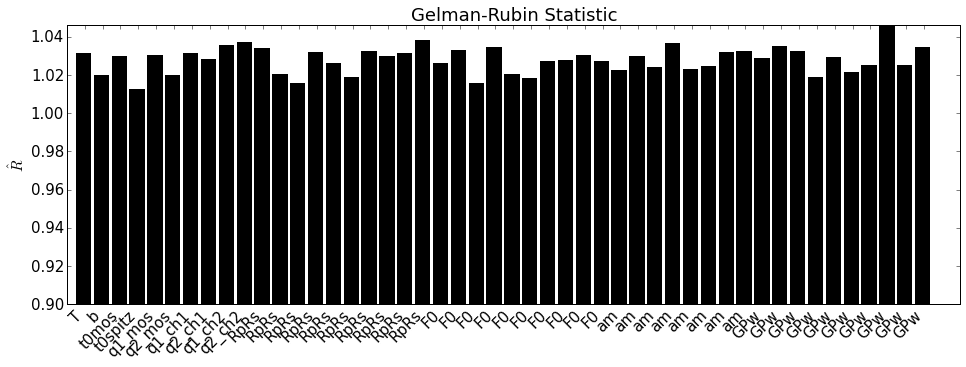

1.04611323346


In [13]:
from moar import stats
Rhats = stats.gelmanrubin(s.samples, labels=s.labels, plot=True)
print np.max(Rhats)

In [125]:
if False:
    max_lnp_ind = np.argmax(lnp)
    max_lnp_params = samples[max_lnp_ind,:]
    np.save('tmpmaxlnp.npy', max_lnp_params)

## Log-likelihood post-burn in

Max ln(p): -25024.2575758


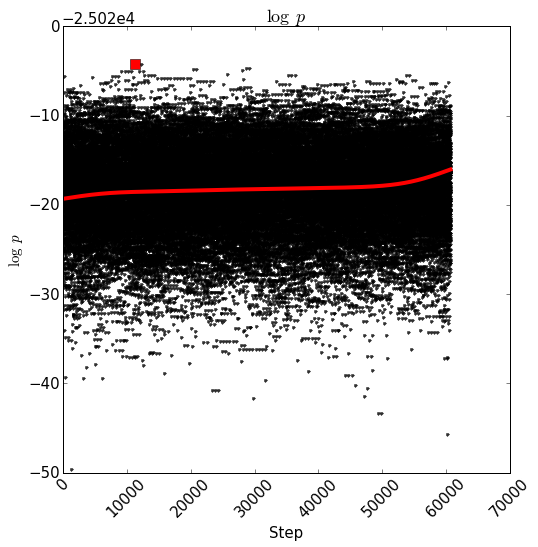

In [14]:
from moar import plots
plots.lnpostprob(lnp, skipfactor=5)

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/text.py:1857: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


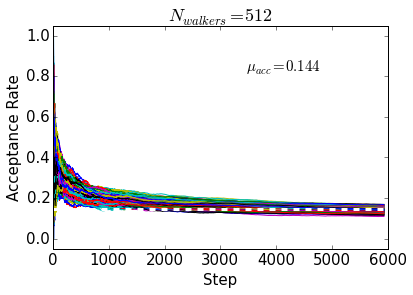

In [15]:
plots.acceptancerate(rundir)

In [71]:
np.shape(s.samples)

(209204, 48)

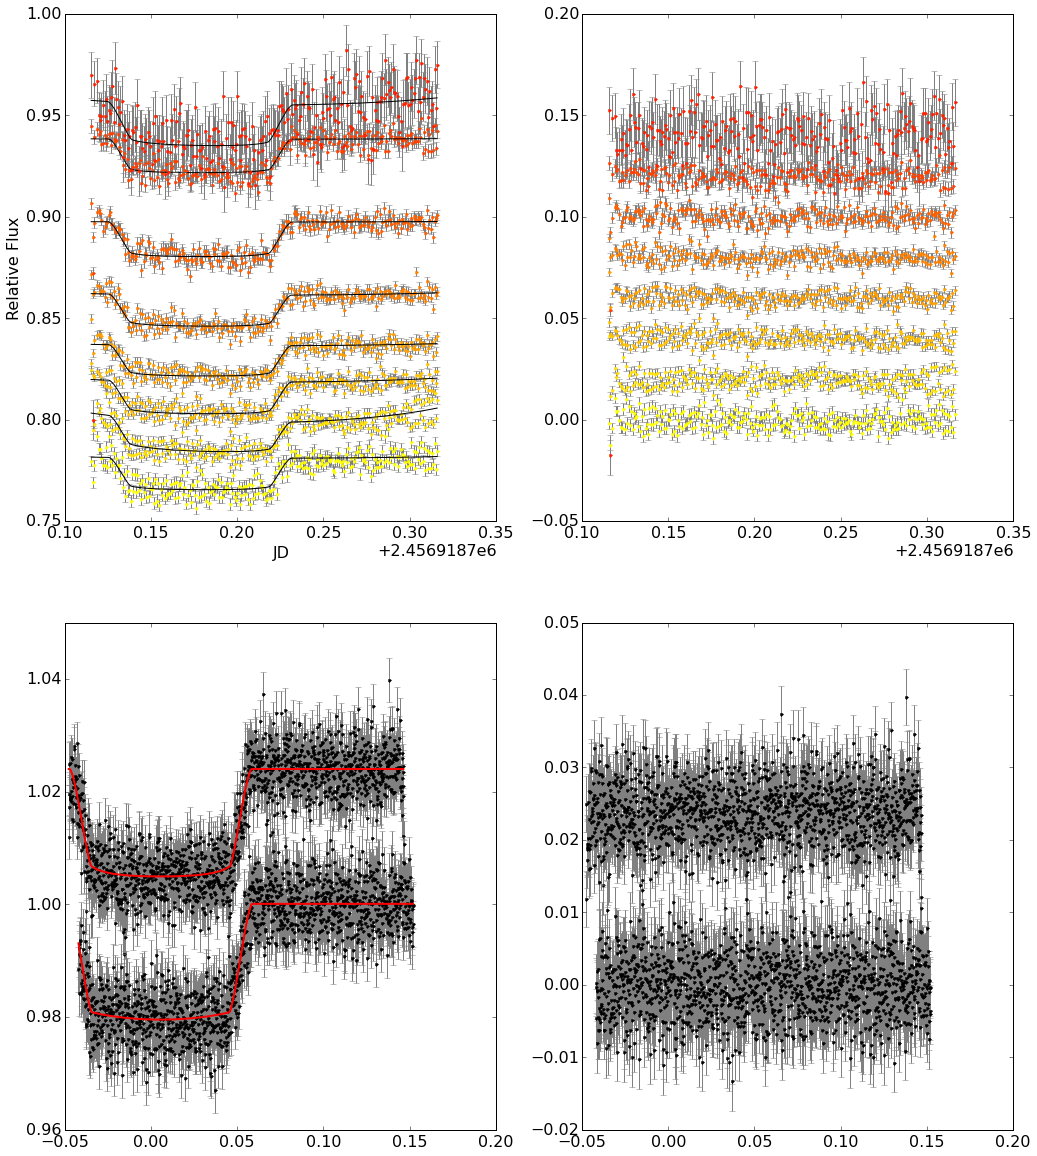

In [9]:
max_lnp_ind = np.argmax(lnp)
max_lnp_params = samples[max_lnp_ind,:]
cmap = plt.cm.autumn
mosfiremodel, ch1model, ch2model = genmodel(max_lnp_params)
fig, ax = plt.subplots(2, 2, figsize=(17,20))
for eachbin in range(len(lightcurve[0,:])):
    ax[0, 0].errorbar(times, lightcurve[:,eachbin] + eachbin*0.02, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax[0, 0].plot(times, mosfiremodel[:,eachbin] + eachbin*0.02, 'k')

    ax[0, 1].errorbar(times, lightcurve[:,eachbin] - mosfiremodel[:,eachbin] + eachbin*0.02, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    
ax[0, 0].set_xlabel('JD')
ax[0, 0].set_ylabel('Relative Flux')
    
for i, ch, model, phases in zip(range(2), [ch2, ch1], [ch2model, ch1model], [-182, -180]):
    ax[1, 0].errorbar(ch['t'] - t0_roughfit - phases*period, ch['f'] + i*0.024, yerr=ch['e'], 
                      fmt='.', color='k', ecolor='gray')
    ax[1, 0].plot(ch['t'] - t0_roughfit - phases*period, model + i*0.024, color='r', lw=2)
    
    ax[1, 1].errorbar(ch['t'] - t0_roughfit - phases*period, ch['f'] - model + i*0.024, yerr=ch['e'], 
                      fmt='.', color='k', ecolor='gray')
    
#ax[0].set_title('Init Params')
plt.show()

In [129]:
# max_lnp_ind = np.argmax(lnp)
# max_lnp_params = samples[max_lnp_ind,:]
# cmap = plt.cm.autumn
# mosfiremodel, ch1model, ch2model = genmodel(max_lnp_params)
# fig, ax = plt.subplots(1, 3, figsize=(17,10))#, dpi=500)
# spreadfactor = 0.03

# #useparams = max_lnp_params
# useparams = np.median(samples, axis=0)

# gp_objs = []
# kernellist = []
# stimes = np.sort(times)
# cosineperiod = 2*np.median(np.diff(stimes))
# # for i in range(Nlightcurves):
# #     # For MOSFIRE light curves:
# #     if i < Nbins:

# mininttime = int(np.min(times))
# mtimes = times - mininttime
# for eachbin in range(len(lightcurve[0,:])):
#     # Gaussian process parameters
#     w = np.exp(useparams[-2*Nbins-Nlightcurves+eachbin])
#     amp = np.exp(useparams[-2*Nbins+eachbin])
#     sig = useparams[-Nbins+eachbin]
    
#     gp_obj = george.GP(amp*kernels.ExpSquaredKernel(sig)*kernels.CosineKernel(cosineperiod))
#     gp_obj.compute(times, w**0.5)
    
#     mu, cov = gp_obj.predict(lightcurve[:,eachbin] - mosfiremodel[:,eachbin], times)
    
#     # Airmass correction
#     am = np.exp(samples[max_lnp_ind,30+eachbin])
#     amcorrection = 1 + (airmass - 1)/am # Divide data, model by this
    
#     errorbarstyle = dict(fmt='.', color=cmap(1 - eachbin / float(Nbins)), 
#                          ecolor='gray', capsize=0)
#     # Raw light curves
#     ax[0].errorbar(mtimes, lightcurve[:,eachbin] + eachbin*spreadfactor, \
#                 yerr=lightcurve_errors[:,eachbin], **errorbarstyle)
#     ax[0].plot(mtimes, mosfiremodel[:,eachbin] + mu + eachbin*spreadfactor, 'k')

#     # Systematics corrected
#     ax[1].errorbar(mtimes, (lightcurve[:,eachbin] - mu)/amcorrection + eachbin*spreadfactor, \
#                 yerr=lightcurve_errors[:,eachbin], **errorbarstyle)
#     ax[1].plot(mtimes, mosfiremodel[:,eachbin]/amcorrection + eachbin*spreadfactor, 'k')

#     #ax[1].plot(times, mu + eachbin*spreadfactor, 'k')

#     # GP, transit subtracted
#     ax[2].errorbar(mtimes, lightcurve[:,eachbin] - mosfiremodel[:,eachbin] - mu + eachbin*spreadfactor, \
#                 yerr=lightcurve_errors[:,eachbin], **errorbarstyle)
    
# ax[1].set_xlabel('JD - {0:d}'.format(mininttime))
# ax[0].set_ylabel('Relative Flux')

# ax[0].set_title('MOSFIRE: Raw')
# ax[1].set_title('Systematics corrected')
# ax[2].set_title('Residuals')
# fig.savefig('plots/mosfiresystematics.pdf',bbox_inches='tight')
# #ax[0].set_title('Init Params')
# plt.show()

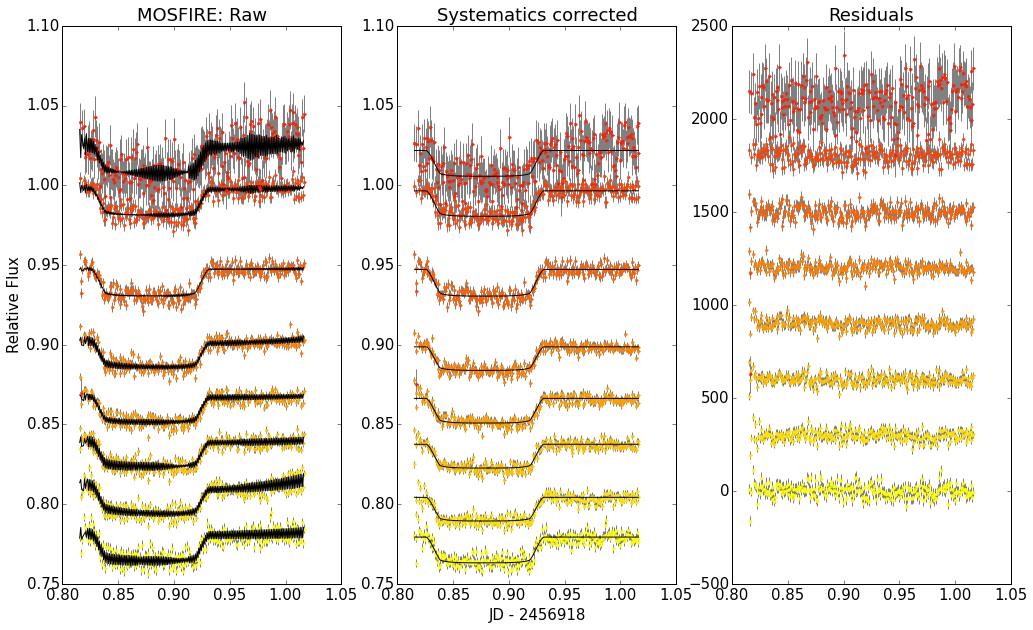

In [16]:
max_lnp_ind = np.argmax(lnp)
max_lnp_params = samples[max_lnp_ind,:]
cmap = plt.cm.autumn
mosfiremodel, ch1model, ch2model = genmodel(max_lnp_params)
fig, ax = plt.subplots(1, 3, figsize=(17,10))#, dpi=500)
spreadfactor = 0.03

#useparams = max_lnp_params
useparams = np.median(samples, axis=0)

gp_objs = []
kernellist = []
stimes = np.sort(times)
cosineperiod = 2*np.median(np.diff(stimes))
# for i in range(Nlightcurves):
#     # For MOSFIRE light curves:
#     if i < Nbins:
def multiplyresiduals(residuals):
    return 1e4*residuals

mininttime = int(np.min(times))
mtimes = times - mininttime
for eachbin in range(len(lightcurve[0,:])):
    # Gaussian process parameters
    w = np.exp(useparams[-2*Nbins-Nlightcurves+eachbin])
    amp = np.exp(useparams[-2*Nbins+eachbin])
    sig = useparams[-Nbins+eachbin]
    
    gp_obj = george.GP(amp*kernels.ExpSquaredKernel(sig)*kernels.CosineKernel(cosineperiod))
    gp_obj.compute(times, (w/1e4)**0.5)
    
    mu, cov = gp_obj.predict(lightcurve[:,eachbin] - mosfiremodel[:,eachbin], times)
    
    # Airmass correction
    am = np.exp(samples[max_lnp_ind,30+eachbin])
    amcorrection = 1 + (airmass - 1)/am # Divide data, model by this
    
    errorbarstyle = dict(fmt='.', color=cmap(1 - eachbin / float(Nbins)), 
                         ecolor='gray', capsize=0)
    # Raw light curves
    ax[0].errorbar(mtimes, lightcurve[:,eachbin] + eachbin*spreadfactor, \
                yerr=lightcurve_errors[:,eachbin], **errorbarstyle)
    ax[0].plot(mtimes, mosfiremodel[:,eachbin] + mu + eachbin*spreadfactor, 'k')

    # Systematics corrected
    ax[1].errorbar(mtimes, (lightcurve[:,eachbin] - mu)/amcorrection + 
                                             eachbin*spreadfactor, \
                yerr=lightcurve_errors[:,eachbin], **errorbarstyle)
        
    ax[1].plot(mtimes,mosfiremodel[:,eachbin]/amcorrection + eachbin*spreadfactor, 'k')

    #ax[1].plot(times, mu + eachbin*spreadfactor, 'k')

    # GP, transit subtracted
    ax[2].errorbar(mtimes, multiplyresiduals(lightcurve[:,eachbin] - mosfiremodel[:,eachbin] - mu 
                   + eachbin*spreadfactor), \
                yerr=multiplyresiduals(lightcurve_errors[:,eachbin]), **errorbarstyle)
    
ax[1].set_xlabel('JD - {0:d}'.format(mininttime))
ax[0].set_ylabel('Relative Flux')

ax[0].set_title('MOSFIRE: Raw')
ax[1].set_title('Systematics corrected')
ax[2].set_title('Residuals')
fig.savefig('plots/mosfiresystematics.pdf',bbox_inches='tight')
#ax[0].set_title('Init Params')
plt.show()

## Parameters linked between all spectral bins

array([ 1.98803952,  2.04011509,  2.09219066,  2.14426622,  2.19634179,
        2.24841736,  2.30049293,  2.3525685 ,  3.6       ,  4.5       ])

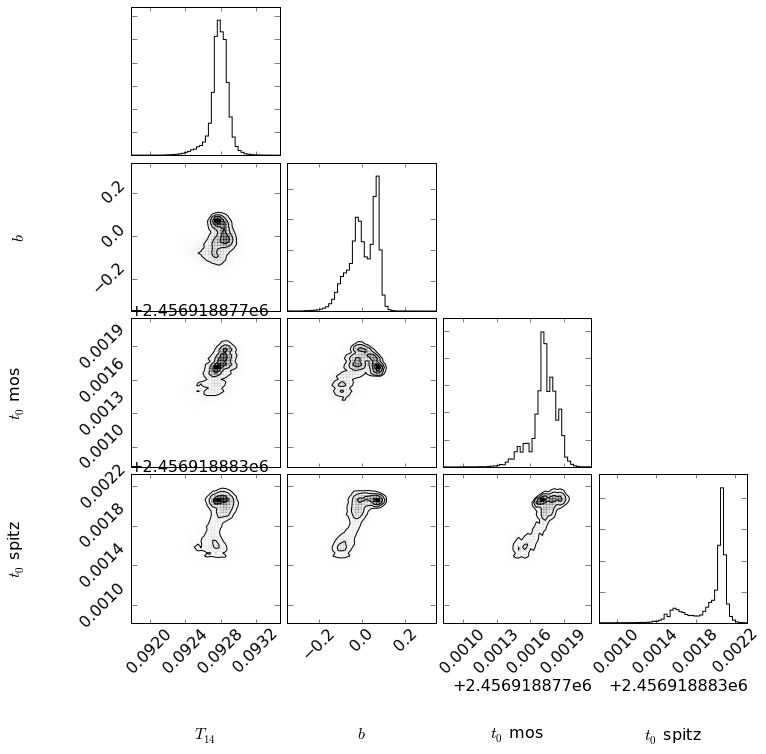

In [141]:
import triangle
import datetime

saveparams = False
if saveparams:
    currenttime = datetime.datetime.now().strftime('%Y%m%d%H%M')
    for directory in ['./', '/local/tmp/mosfire/longchains/mosfirespitzer/']:
        print directory+'max_lnp_params_'+currenttime+'.npy'
        np.save(directory+'max_lnp_params_'+currenttime+'.npy', max_lnp_params)

trifig, ax = plt.subplots(4, 4, figsize=(10, 10))
fig2 = triangle.corner(samples[:, 0:4], labels=['$T_{14}$','$b$','$t_0$ mos', '$t_0$ spitz'], 
                       fig=trifig, plot_datapoints=False)#, truths=max_lnp_params[0:4]) # truths=[t0_expected, aOverRs, RpOverRs, scale, 1]
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

(0.11048976000000002, 0.2023164861612515, 0.052486810000000002, 0.24727193365342645, 0.16999128999999999, -0.12866844530681543)


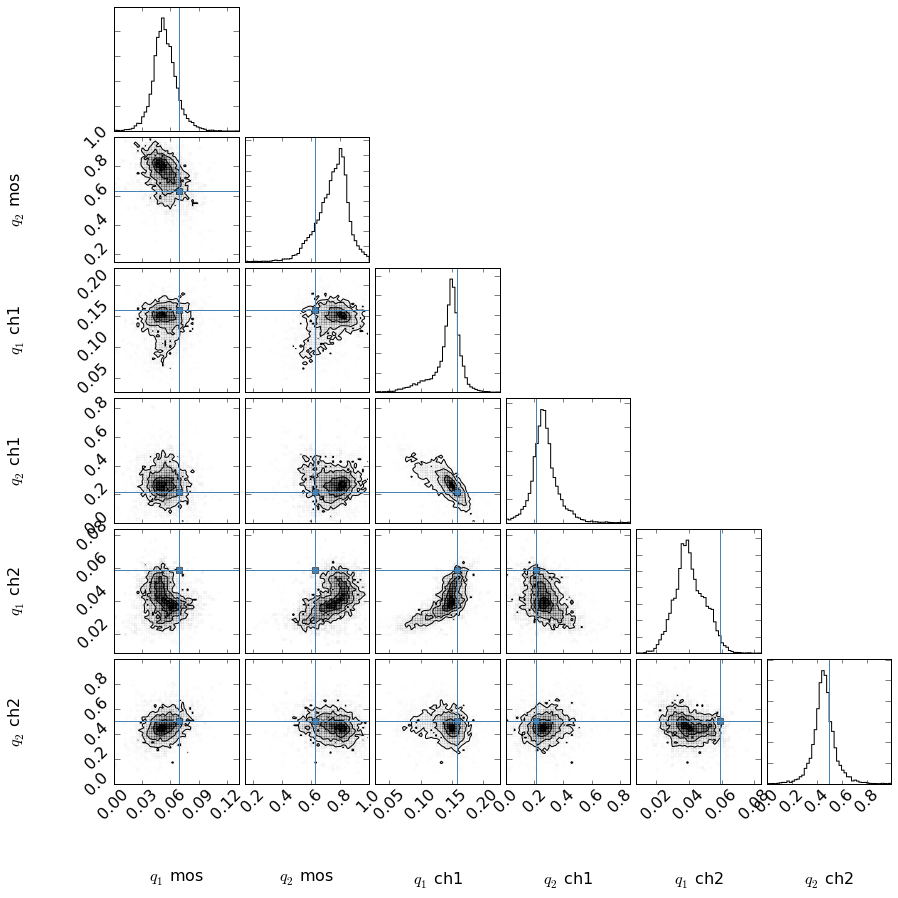

In [108]:
# Triangle plots for limb darkening parameters
trifig, ax = plt.subplots(6, 6, figsize=(12, 12))
qlabels = ['$q_1$ mos','$q_2$ mos'] + ['$q_1$ ch1','$q_2$ ch1'] + ['$q_1$ ch2','$q_2$ ch2']

from moar.claretld import quad, u2q
Teff = 5375
logg = 4.61
mosfireqs = u2q(*quad(Teff, logg, 'K'))
chi1_qs = u2q(*quad(Teff, logg, 'S1'))
chi2_qs = u2q(*quad(Teff, logg, 'S2'))
truths = mosfireqs + chi1_qs + chi2_qs
print truths

fig2 = triangle.corner(samples[::2, 4:10], labels=qlabels, 
                       fig=trifig, plot_datapoints=False, 
                       truths=max_lnp_params[4:10])
                       #truths=truths)
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

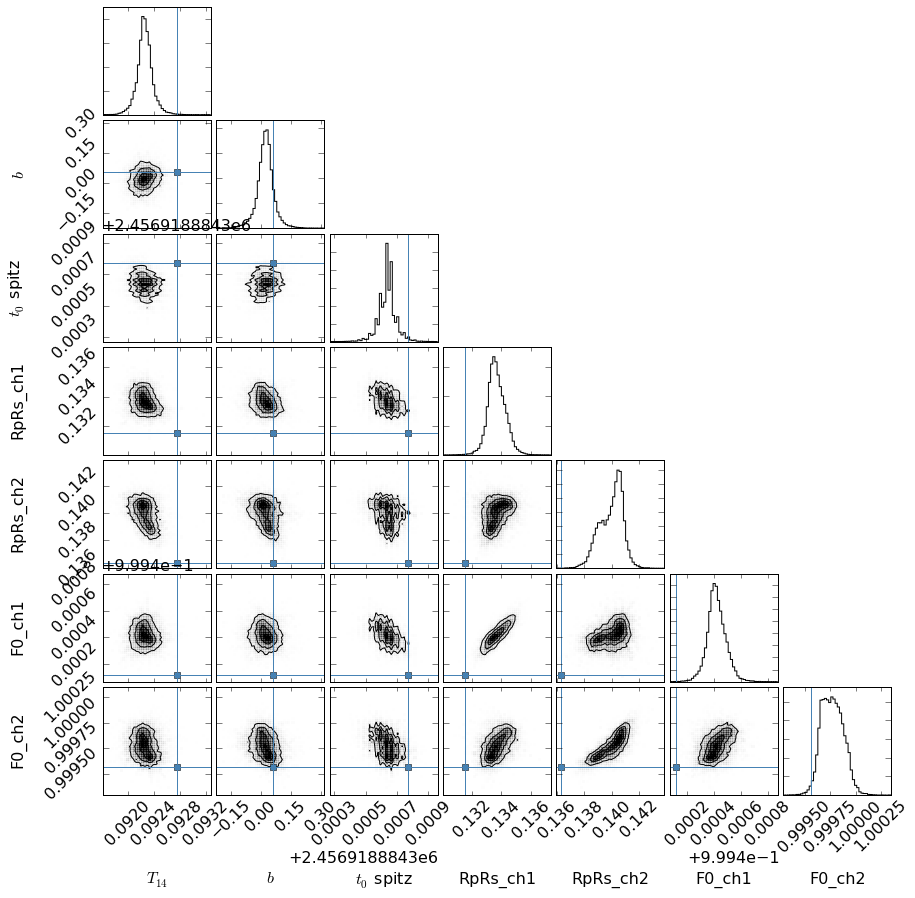

In [475]:
# Triangle plots for limb darkening parameters
spitzlabels = ['$T_{14}$','$b$', '$t_0$ spitz'] + ['RpRs_ch1','RpRs_ch2'] + ['F0_ch1','F0_ch2']
inds = [0, 1, 3, 18, 19, 28, 29]
trifig, ax = plt.subplots(len(inds), len(inds), figsize=(12, 12))
fig2 = triangle.corner(samples[::, inds], labels=spitzlabels, 
                       fig=trifig, plot_datapoints=False,
                      truths=max_lnp_params[inds]) # truths=[t0_expected, aOverRs, RpOverRs, scale, 1]
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

In [474]:
# Triangle plots for limb darkening parameters
import triangle
from moar import stats
reload(stats)
firstchain = '/local/tmp/mosfire/longchains/mosfirespitzer/chain.dat'
laststate = stats.getlastchainstate(firstchain)

mosfiremodel, ch1model, ch2model = genmodel(laststate[0])#+Nlightcurves*[0])

initws = []
for i in range(Nlightcurves):
    if i < Nbins:
        initws.append(np.std(lightcurve[:,i] - mosfiremodel[:,i]))
    elif i == 8:
        initws.append(np.std(ch1['f'] - ch1model))
    elif i == 9:
        initws.append(np.std(ch2['f'] - ch2model))
initws = np.log(np.power(initws,2))
print initws

KeyboardInterrupt: 

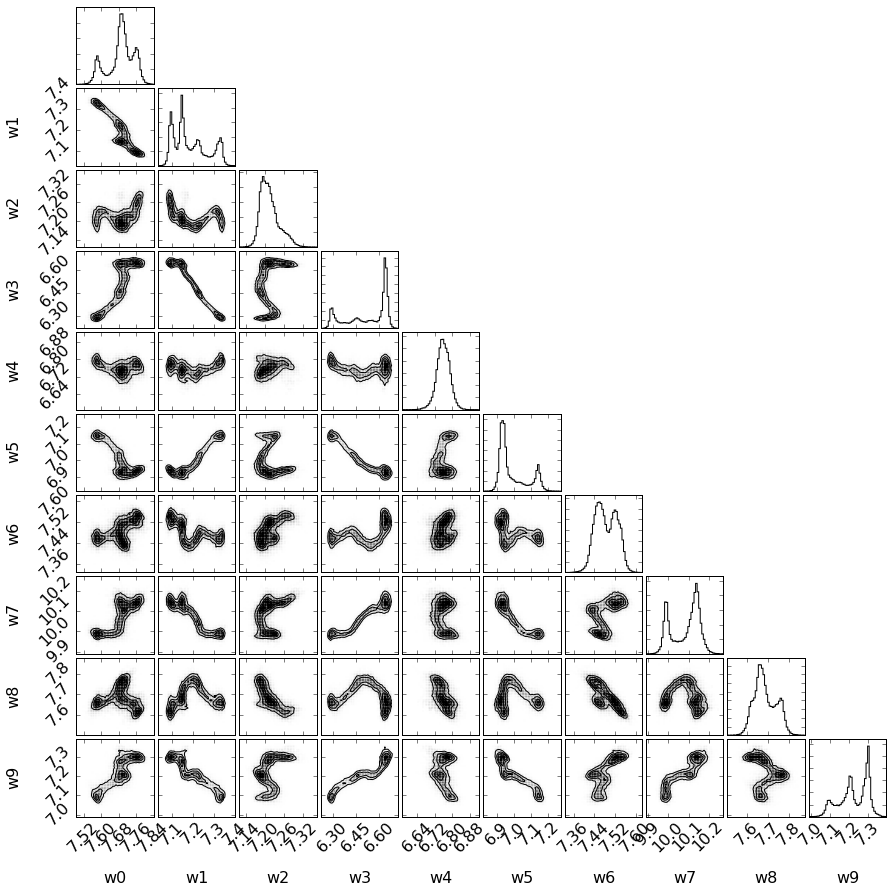

In [25]:
wlabels = ['w'+str(i) for i in range(Nlightcurves)]

#inds = #range(38,48)
ws = samples[::1, -Nlightcurves-2*Nbins:-2*Nbins]
trifig, ax = plt.subplots(ws.shape[1], ws.shape[1], figsize=(12, 12))
fig2 = triangle.corner(ws, labels=wlabels, 
                       fig=trifig, plot_datapoints=False)#, 
                       #truths=max_lnp_params[-Nlightcurves])#truths=initws)
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

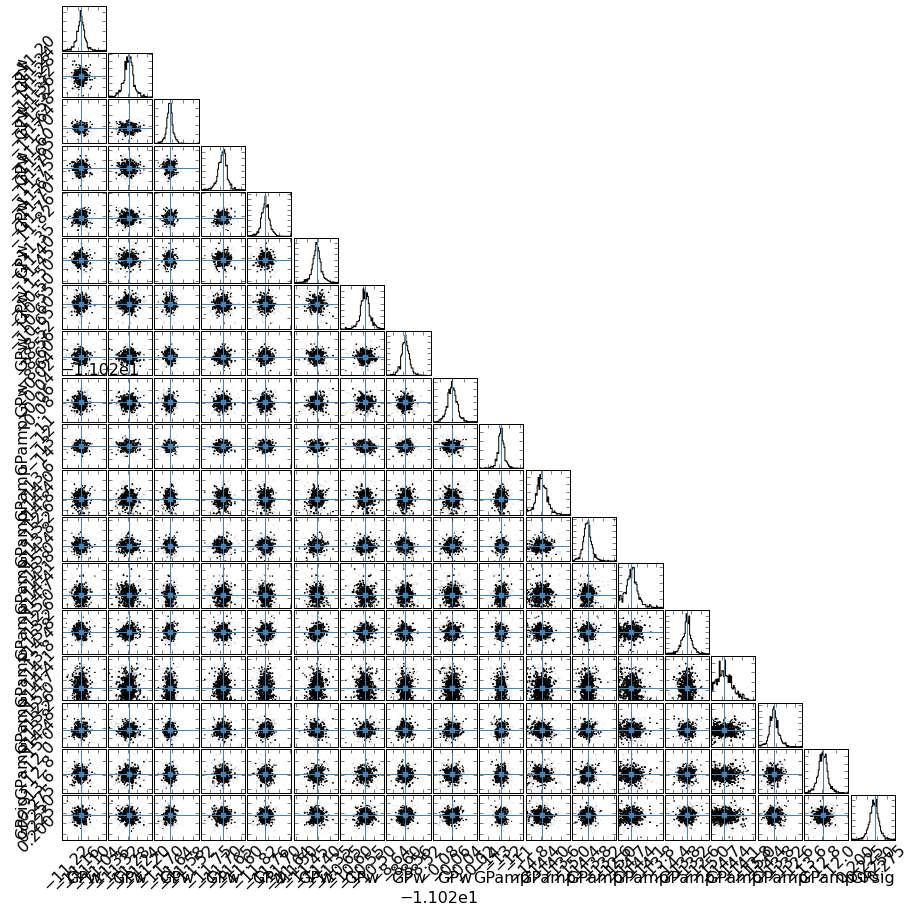

In [264]:
#wlabels = ['w'+str(i) for i in range(Nlightcurves)]
inds = range(38,47) + range(48, 57)
theselabels = np.array(labels)[inds]
trifig, ax = plt.subplots(len(inds), len(inds), figsize=(12, 12))
fig2 = triangle.corner(samples[::1, inds], labels=theselabels, 
                       fig=trifig, plot_datapoints=False, 
                       truths=max_lnp_params[inds])#truths=initws)
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

In [192]:
def medplusminus(vector):
    v = np.percentile(vector, [16, 50, 84])
    return v[1], v[2]-v[1], v[1]-v[0]

m, n = np.shape(samples)
print m, n
scattercoeffs = np.zeros(n)
for i in range(n):
    scattercoeffs[i] = 1.7*np.mean(medplusminus(samples[::1, i])[1:])
print scattercoeffs

297464 48
[  1.37648812e-01   1.50981402e-02   2.89000222e-04   2.54999963e-04
   6.07542540e-02   2.93964370e-01   2.32824016e-02   5.10408131e-01
   1.56487037e-02   3.38998483e-01   4.50197180e-03   3.43473406e-03
   3.51389542e-03   3.36813599e-03   3.11130188e-03   3.66003708e-03
   4.88451365e-03   1.45813033e-02   1.43517228e-03   1.60823971e-03
   2.36459893e-03   1.39080991e-03   1.53287099e-03   1.37423920e-03
   1.60119571e-03   1.01271526e-03   1.70498892e-03   7.34114233e-03
   2.30457684e-04   2.85932865e-04   1.22153018e+00   1.79628539e-01
   8.21407935e-01   1.41027910e+00   8.29207938e-01   2.59324229e+00
   2.28449395e+00   2.58111379e+00   1.52296905e-01   1.47304729e-01
   1.44394044e-01   1.56918049e-01   1.74285908e-01   1.57245560e-01
   1.48954900e-01   1.62271178e-01   7.91935475e-02   7.86389229e-02]


# Results

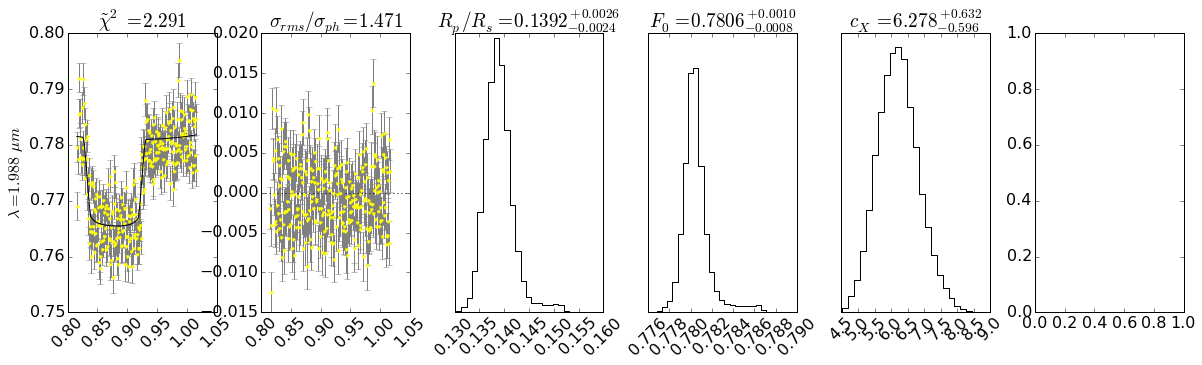

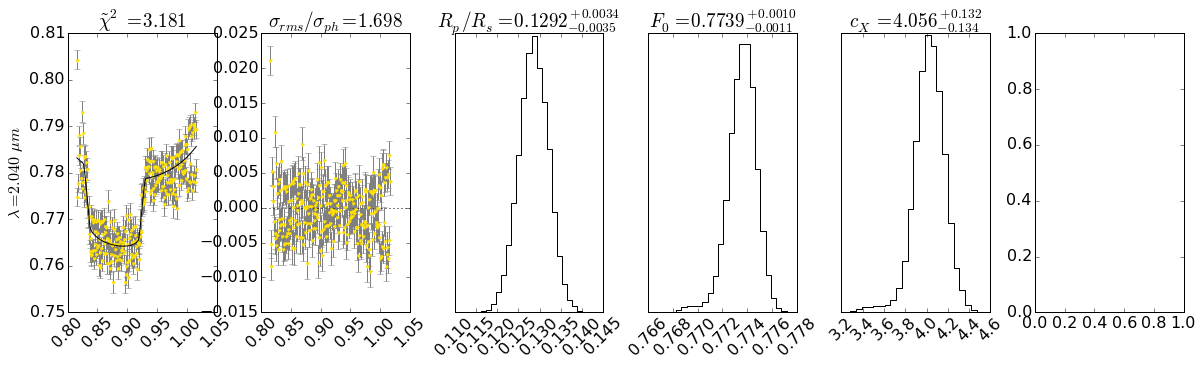

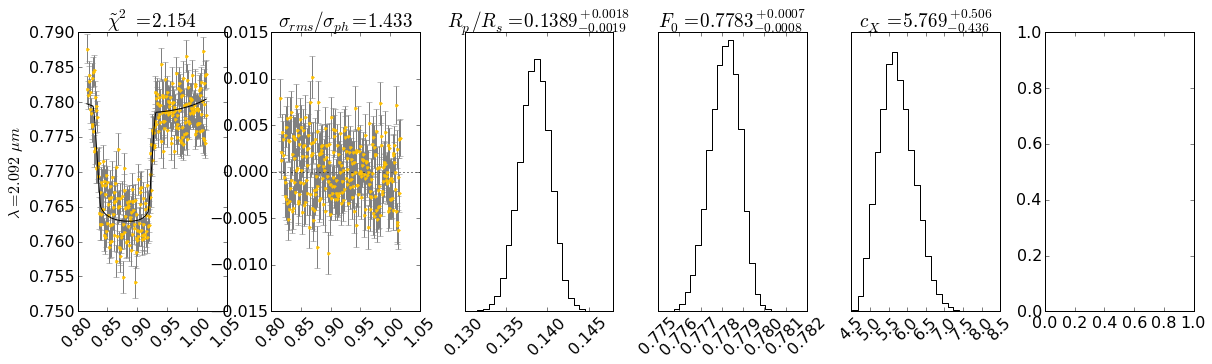

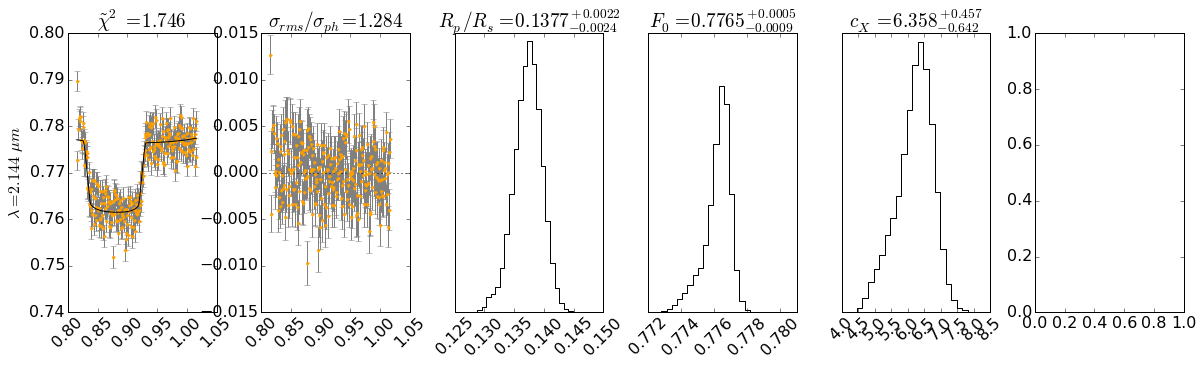

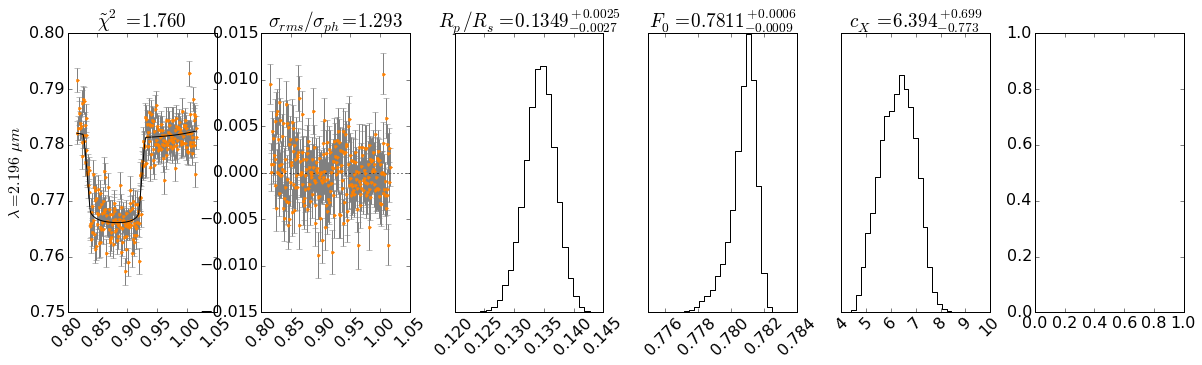

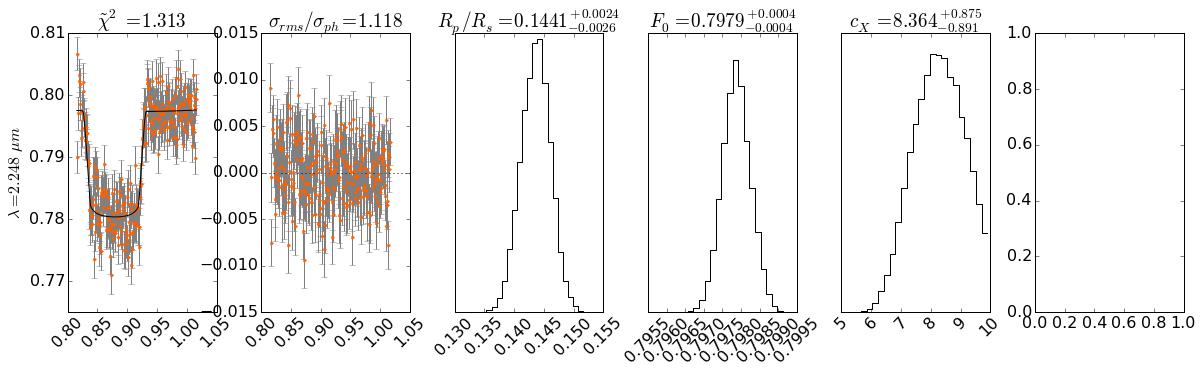

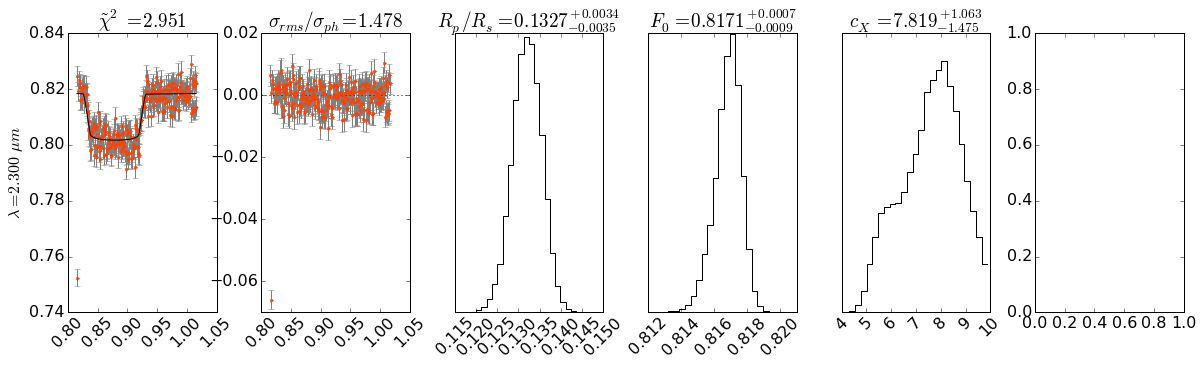

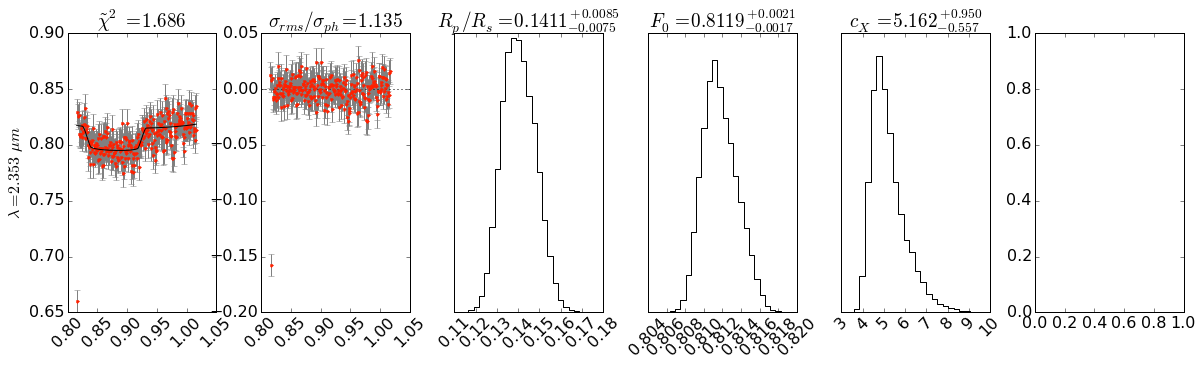

In [11]:
import matplotlib.gridspec as gridspec
matplotlib.rcParams['font.size'] = 16

def chi2(v1, v2, err, Nfreeparams):
    return np.sum( ((v1-v2)/err)**2 )/(len(v1) - Nfreeparams)

Nphotonnoise = np.zeros(Nbins)
mintimeint = int(np.min(times))
for eachbin, j in enumerate(range(2*Nbins)[::2]):
    fig = plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1, 6, wspace=0.3)
    #left_lower = plt.subplot(gs[1, 0])
    left_upper = plt.subplot(gs[0, 0])
    middle_left = plt.subplot(gs[0, 1])
    middle_right = plt.subplot(gs[0, 2])
    right = plt.subplot(gs[0, 3])
    moreright = plt.subplot(gs[0, 4])
    moremoreright = plt.subplot(gs[0, 5])
    model = mosfiremodel
    # Plot lightcurve
    left_upper.errorbar(times - mintimeint, lightcurve[:,eachbin], \
                yerr=lightcurve_errors[:,eachbin], fmt='.', \
                color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    left_upper.plot(times - mintimeint, model[:,eachbin], 'k')
    left_upper.set_ylabel(r'$\lambda = %.3f\,\mu m$' % wavelengthbincenters[eachbin])
    left_upper.set_title(r'$\tilde{\chi}^2 = %.3f$' % chi2(lightcurve[:,eachbin], \
                         model[:,eachbin], lightcurve_errors[:,eachbin], 8))
    [l.set_rotation(45) for l in left_upper.get_xticklabels()]
    
    # Plot residuals
    middle_left.axhline(0, ls=':', color='k')
    middle_left.errorbar(times - mintimeint, lightcurve[:,eachbin] - model[:,eachbin], \
                yerr=lightcurve_errors[:,eachbin], fmt='.', \
                color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    Nphotonnoise[eachbin] = np.std(lightcurve[:,eachbin] - model[:,eachbin])/np.mean(lightcurve_errors[:,eachbin])
    middle_left.set_title(r'$\sigma_{rms}/\sigma_{ph} = %.3f$' % \
                          Nphotonnoise[eachbin])
    [l.set_rotation(45) for l in middle_left.get_xticklabels()]
    
    # Plot RpRs histogram
    Nhistbins = 25
    n, edges = np.histogram(samples[:,10+eachbin], Nhistbins)
    x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
    middle_right.plot(x, n, color='k', ls='steps')
    middle_right.set_yticks([])
    #middle_right.set_xlim([0.128, 0.148])
    middle_right.set_title(r'$R_p/R_s = %.4f^{+%.4f}_{-%.4f}$' % medplusminus(samples[:,10+eachbin]))
    [l.set_rotation(45) for l in middle_right.get_xticklabels()]

    # Plot F0 histogram
    n, edges = np.histogram(samples[:,20+eachbin], Nhistbins)
    x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
    right.plot(x, n, color='k', ls='steps')
    right.set_yticks([])
    right.set_title(r'$F_0 = %.4f^{+%.4f}_{-%.4f}$' % medplusminus(samples[:,20+eachbin]))
    [l.set_rotation(45) for l in right.get_xticklabels()]

    # Plot airmass histogram
    n, edges = np.histogram(samples[:,30+eachbin], Nhistbins)
    x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
    moreright.plot(x, n, color='k', ls='steps')
    moreright.set_yticks([])
    moreright.set_title(r'$c_X = %.3f^{+%.3f}_{-%.3f}$' % medplusminus(samples[:,30+eachbin]))
    [l.set_rotation(45) for l in moreright.get_xticklabels()]

    
    # Plot white noise
#     n, edges = np.histogram(samples[:,38+eachbin], Nhistbins)
#     x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
#     moremoreright.plot(x, n, color='k', ls='steps')
#     moremoreright.set_yticks([])
#     moremoreright.set_title(r'$w = %.3f^{+%.3f}_{-%.3f}$' % medplusminus(samples[:,38+eachbin]))
#     [l.set_rotation(45) for l in moremoreright.get_xticklabels()]    
    
    
    #fig.savefig('plots/%02d.pdf' % eachbin, bbox_inches='tight')
    #fig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/%02d.eps' % eachbin, bbox_inches='tight')
plt.show()

In [28]:
with open('MOSFIREresults.txt', 'w') as f:
    for eachbin in range(Nbins):
        s = '{0:.4f} {1:.4f} {2:.4f} {3:.4f} {4:.4f}'.format(
                wavelengthbounds[eachbin][0],wavelengthbounds[eachbin][1], *medplusminus(samples[:,10+eachbin]))
        print s
        f.write(s+'\n')


1.9620 2.0141 0.1351 0.0023 0.0024
2.0141 2.0662 0.1337 0.0018 0.0018
2.0662 2.1182 0.1357 0.0018 0.0019
2.1182 2.1703 0.1361 0.0018 0.0019
2.1703 2.2224 0.1370 0.0018 0.0018
2.2224 2.2745 0.1431 0.0019 0.0019
2.2745 2.3265 0.1362 0.0025 0.0024
2.3265 2.3786 0.1394 0.0071 0.0071


In [501]:
# Make triangle plots for RpRs/F0/c_x:
matplotlib.rcParams['font.size'] = 14
reload(triangle)
import triangle

timesinds = [2]
shortenedsamples = samples.copy()
shortenedsamples[:,timesinds] -= np.median(shortenedsamples[:,timesinds])

for eachbin in range(Nbins):
    showparams = [0, 1, 2, 4, 5, 10+eachbin, 20+eachbin, 30+eachbin]
    trifig, ax = plt.subplots(len(showparams), len(showparams), figsize=(10, 10))
    fig2 = triangle.corner(shortenedsamples[:, showparams], labels=['$a/R_s$',
                           '$i$','$t_0$', '$q_1$', '$q_2$', '$R_p/R_s$', '$F_0$', '$c_X$'], 
                           fig=trifig)#, truths=max_lnp_params[0:4])

    trifig.savefig('mosfiretriangles/{0:02d}.png'.format(eachbin), bbox_inches='tight')
    plt.clf()

# Candidate Spectrum

NameError: global name 'medplusminus' is not defined

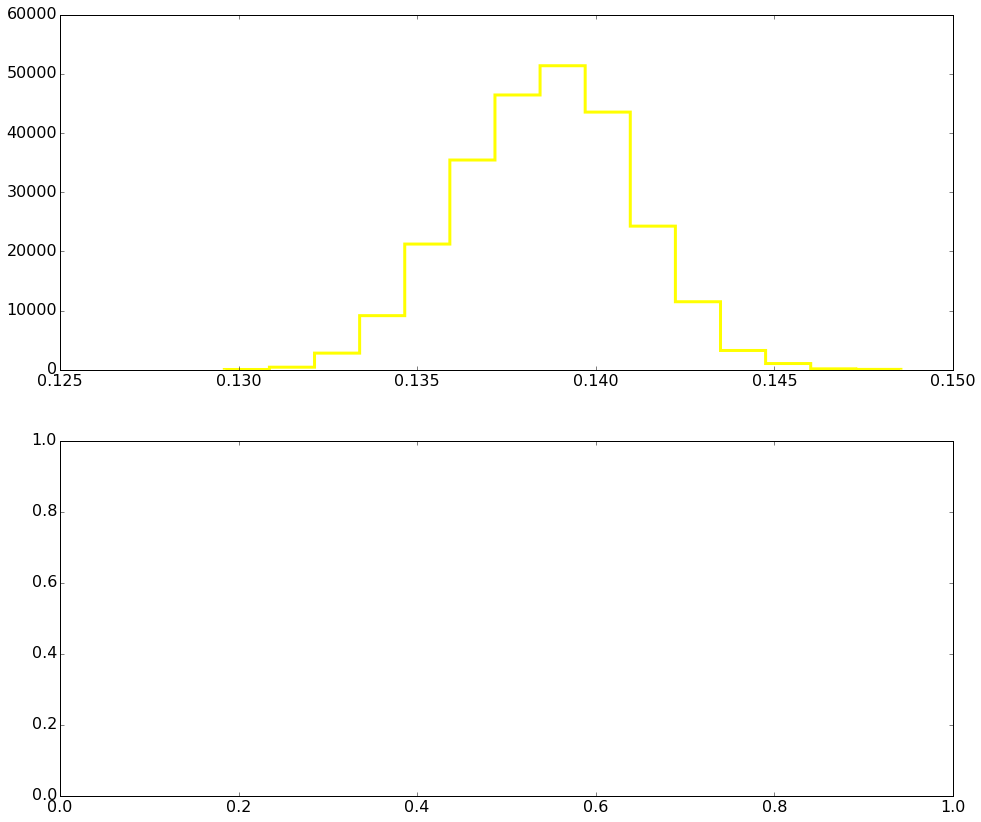

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(16,14))
histbins = 15
nikolovdata = np.loadtxt('../leftnod/nikolov.dat')

def depthhist(ax, eachbin, cmap=plt.cm.autumn):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    RpRs = samples[:,10+eachbin]
    ax[0].hist(RpRs, histbins, histtype='step', \
               
               label='$%.3f\mu m$' % wavelengthbincenters[eachbin],\
               color=cmap(1 - i/float(len(wavelengthbincenters))), lw=3)
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,10+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax[1].errorbar(wavelengthbincenters[eachbin], bestRpRs, yerr=[[bestRpRsminus], [bestRpRsplus]], \
                  fmt='s', color=cmap(1 - i/float(len(wavelengthbincenters))), \
                  ecolor='k', markeredgecolor='none', ms=10)

binwidth_nik = 0.5*(nikolovdata[:,1]-nikolovdata[:,0])*1e-4

def depthhistspitz(ax, eachbin, cmap=plt.cm.winter):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    wavelengthbincenters_spitz = [3.5, 4.5]

    RpRs = samples[:,18+eachbin]
    ax[0].hist(RpRs, histbins, histtype='step', \
               
               label='$%.3f\mu m$' % wavelengthbincenters_spitz[eachbin],\
               color=cmap(1 - i/float(len(wavelengthbincenters_spitz))), lw=3)
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,18+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    ax[1].errorbar(wavelengthbincenters_spitz[eachbin], bestRpRs, 
                xerr=[binwidth_nik[-2:][eachbin]], yerr=[[bestRpRsminus], [bestRpRsplus]], 
                  fmt='s', color=cmap(1 - i/float(len(wavelengthbincenters_spitz))), 
                  ecolor='k', markeredgecolor='none', ms=10)
    
for i in range(Nbins):
    depthhist(ax, i)
    
for i in range(2):
    depthhistspitz(ax, i)
    
ax[0].legend(fontsize=14)
ax[0].set_xlabel(r'$R_p/R_*$', fontsize=16)
ax[0].set_title(r'$R_p/R_*$ Posteriors',fontsize=16)
ax[0].set_yticks([0])

ax[1].set_xscale('log')

ax[1].set_xlabel('Wavelength [$\mu m$]', fontsize=16)
ax[1].set_ylabel(r'$R_p/R_*$', fontsize=16)

ax[1].set_xlim([1.8, 5])
xticks = [1.9, 2.1, 2.3, 2.5, 3.0, 3.5, 4.0, 4.5]
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(map("{0}".format, xticks))

plt.show()

## Comparison with [Jordan et al. (2013)](http://adsabs.harvard.edu/abs/2013ApJ...778..184J) and [Nikolov et al. (2014)](http://arxiv.org/abs/1411.4567)

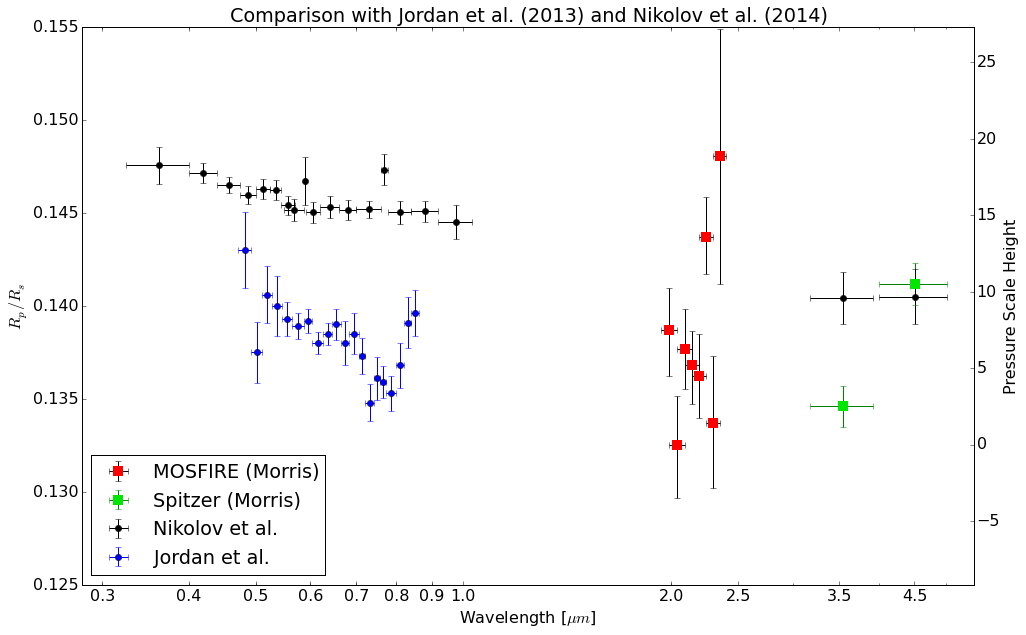

In [33]:
# MOSFIRE binwidth 
#mosfirebinwidth = 0.5*(wavelengthbincenters[1] - wavelengthbincenters[0])

def medplusminus(vector):
    v = np.percentile(vector, [16, 50, 84])
    return v[1], v[2]-v[1], v[1]-v[0]
# Read in Nikolov data
nikolovdata = np.loadtxt('../leftnod/nikolov.dat')
wave_nik = np.mean([nikolovdata[:,0],nikolovdata[:,1]],axis=0)*1e-4
binwidth_nik = 0.5*(nikolovdata[:,1]-nikolovdata[:,0])*1e-4
RpRs_nik = nikolovdata[:,2]
RpRsUnc_nik = nikolovdata[:,3]

# Read in Jordan data
jordandata = np.loadtxt('../leftnod/jordan.dat')
wave_jordan = np.mean([jordandata[:,0],jordandata[:,1]],axis=0)*1e-4
binwidth_jordan = 0.5*(jordandata[:,1]-jordandata[:,0])*1e-4
RpRs_jordan = jordandata[:,2]
RpRsUnc_jordan = np.mean([jordandata[:,3],np.abs(jordandata[:,4])],axis=0)

def depthhist(ax, eachbin):
    RpRs = samples[:,10+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,10+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)
    binwidth = wavelengthbincenters[1]-wavelengthbincenters[0]
    if eachbin == 0:
        kwargs = {'label' : 'MOSFIRE (Morris)'}
    else: 
        kwargs = {}
    ax.errorbar(wavelengthbincenters[eachbin], bestRpRs, xerr=[[binwidth], [binwidth]],
                 yerr=[[bestRpRsminus], [bestRpRsplus]], \
                  fmt='s', color='r', ecolor='k', markeredgecolor='none', ms=10, **kwargs)
    #color=cmap(1 - i/float(len(wavelengthbincenters))), \
    return bestRpRs

def depthhistspitz(ax, eachbin, cmap=plt.cm.winter):
    #samples = np.load('outputs/bin%02d.npy' % binindex)
    #depth = samples[:,2]**2
    wavelengthbincenters_spitz = wave_nik[-2:]#[3.5, 4.5]

    RpRs = samples[:,18+eachbin]
    bestRpRs, bestRpRsplus, bestRpRsminus = medplusminus(samples[:,18+eachbin])
    bestRpRserr = 0.5*(bestRpRsplus+bestRpRsminus)

    if eachbin == 0:
        kwargs = {'label' : 'Spitzer (Morris)'}
    else: 
        kwargs = {}
    ax.errorbar(wavelengthbincenters_spitz[eachbin], bestRpRs, 
                xerr=[binwidth_nik[-2:][eachbin]], yerr=[[bestRpRsminus], [bestRpRsplus]], 
                  fmt='s', color='#00E600', ecolor='g', markeredgecolor='none',
                  ms=10, **kwargs)
    return bestRpRs
    #color=cmap(1 - i/float(len(wavelengthbincenters_spitz))),

matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, figsize=(16,10))

# Plot MOSFIRE
radii = []
waves = np.concatenate((wavelengthbincenters, wave_nik[-2:]))
for i in range(Nbins):
    radii.append(depthhist(ax, i))

# Plot Spitzer
for i in range(2):
    radii.append(depthhistspitz(ax, i))

# Plot Nikolov, Jordan
ax.errorbar(wave_nik, RpRs_nik, yerr=RpRsUnc_nik, xerr=binwidth_nik, 
            fmt='o', color='k', label='Nikolov et al.')
ax.errorbar(wave_jordan, RpRs_jordan, yerr=RpRsUnc_jordan, 
            xerr=binwidth_jordan, fmt='o', color='b', label='Jordan et al.')


## Calculate Rp/Rs -> pressure scale heights
from astropy.constants import G, k_B, M_jup, m_p, R_sun
from astropy import units as u

def scaleheights(RpRs):
    '''
    Compute scale heights at deepest radius, then return Nscaleheights for
    each radius.
    '''
    minRpRs = np.min(RpRs)
    Rs = 0.870*R_sun                # Gillon 2009
    Mp = 0.503*M_jup                # Gillon 2009
    minRp = minRpRs*Rs
    g = G*Mp/(minRp**2)
    mu = 2*m_p                      # Assuming H2 dominated atmos
    T = 1194                        # Gillon 2009
    minH = ( k_B*T/(mu*g) ).value

    #allRp = np.array([(RpRs_i*Rs).value for RpRs_i in RpRs])
    #Hs = [(Rp_i-minRp.value)/minH for Rp_i in allRp]
    Hs = lambda allRpRs: [((RpRs_i*Rs).value-minRp.value)/minH for RpRs_i in allRpRs]
    return Hs


initxlim = ax.get_xlim()
initylim = ax.get_ylim()

Hs = scaleheights(radii)
ax2 = ax.twinx()
ax2.plot(waves, Hs(radii), ',', alpha=0)
#ax2.set_xlim(initxlim)
ax2.set_ylim(Hs(initylim))
ax2.set_ylabel('Pressure Scale Height')

for axis in [ax, ax2]:
    axis.set_xlim([0.28, 5.5])
    axis.set_xscale("log")
    xticklist = np.arange(0.3, 1.1, 0.1).tolist() + [2.0, 2.5, 3.5, 4.5]
    axis.set_xticks(xticklist)
    axis.set_xticklabels(map(lambda x: '%.1f' % x, xticklist))
ax.set_title('Comparison with Jordan et al. (2013) and Nikolov et al. (2014)')

ax.set_ylabel('$R_p/R_s$')
ax.set_xlabel('Wavelength [$\mu m$]')
ax.legend(loc='lower left', numpoints=1)
fig.savefig('plots/comparison.png', bbox_inches='tight')
plt.show()

In [204]:
paddingbounds = [110, 2130]
spectralbinbounds = np.linspace(paddingbounds[0], paddingbounds[1], Nbins+1, dtype=int)
print spectralbinbounds

firstlines = \
'''
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
physical
'''

# Box format:
# centerx centery widthx widthy rot
with open('binregions.reg','w') as reg:
    for i in range(len(spectralbinbounds)-1):
        centerx =  0.5*(spectralbinbounds[i] + spectralbinbounds[i+1])
        centery = 2024/2
        widthx = spectralbinbounds[i+1] - spectralbinbounds[i]
        widthy = 2024
        angle = 0
        linewidth = 3
        wavelength = wavelengthbincenters[i]
        reg.write("box({0:f},{1:f},{2:f},{3:f},{4:f}) # width={5} text={{{6:.3f}}} \n".format(
                  centerx, centery, widthx, widthy, angle, linewidth, wavelength))

[ 110  312  514  716  918 1120 1322 1524 1726 1928 2130]


## Compare MOSFIRE+Spitzer fits with TAP Spitzer fits

[[ 0.13125788  0.0026918   0.00256984]
 [ 0.14156172  0.00189539  0.00204403]]


TypeError: 'AxesSubplot' object does not support indexing

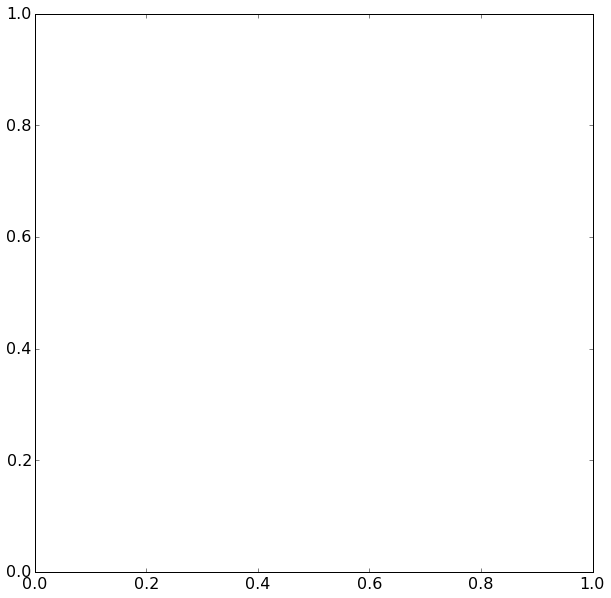

In [31]:
tapresults = np.loadtxt('TAP/TAPmcmc_20150202_1113/RpRsTAP.txt')

print tapresults
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(2):
    depthhistspitz(ax, i)
    
def medplusminus(vector):
    v = np.percentile(vector, [16, 50, 84])
    return v[1], v[2]-v[1], v[1]-v[0]
    
ax.errorbar(wave_nik[-2:], tapresults[:,0], xerr=[binwidth_nik[-2:], binwidth_nik[-2:]],
            yerr=[tapresults[:,1], tapresults[:,2]], fmt='s', color='r', elinewidth=2, capsize=8, label='TAP')
ax.legend(loc='lower right')
ax.set_ylabel('$R_p/R_s$')
ax.set_xlabel('Wavelength [$\mu m$]')
plt.show()

275968 64


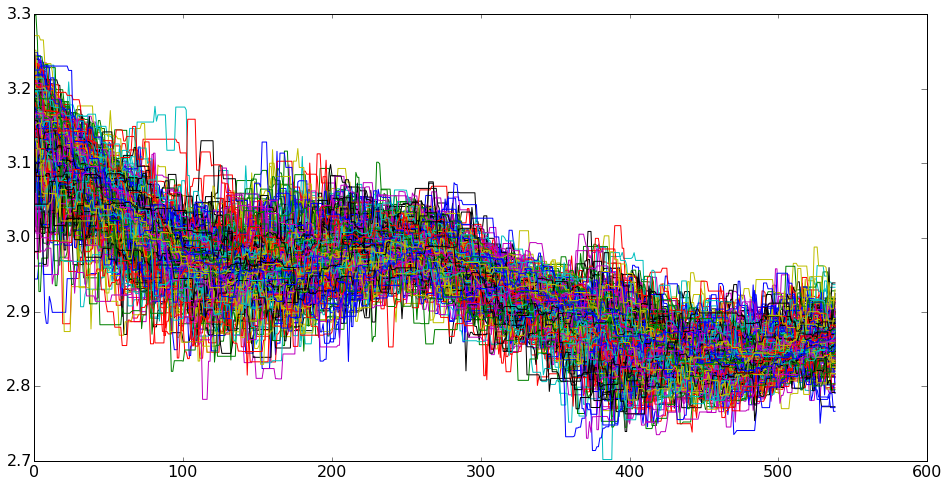

In [209]:
fig, ax = plt.subplots(figsize=(16,8))
n, m  = samples.shape
print n, m
#skipfactor = Nwalkerfactor*m
Nwalkerfactor = 10
skipfactor = 512 #= Nwalkerfactor*m
for j in [31]:
    [ax.plot(samples[i:,j][::skipfactor]) for i in range(skipfactor)]
    #[ax.plot(lnp[j::Nwalkerfactor*m]) for i in range(Nwalkerfactor*m)]
    plt.show()

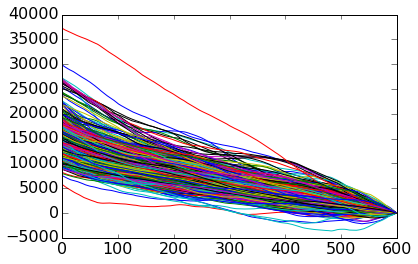

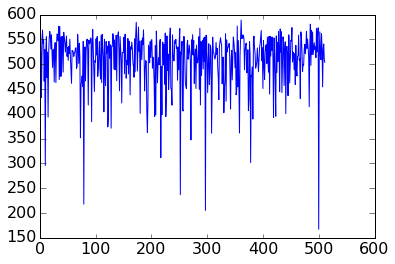

In [539]:
# Autocorrelation time
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]
def autocorrtime(x):
    ac = autocorr(x)
    return 1 + 2*np.sum(ac/ac[0])

tau_f = np.zeros(skipfactor)
for i in range(skipfactor):
    ac = autocorr(samples[i:,48][::skipfactor])
    tau_f[i] = autocorrtime(samples[i:,48][::skipfactor])
    plt.plot(ac)
#plt.xlim([500,650])
#plt.ylim([-5000,5000])
plt.show()

plt.plot(tau_f)
plt.show()

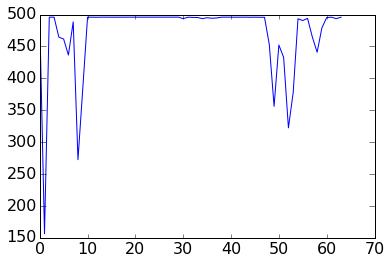

In [573]:

tau_fs = np.zeros(len(labels))
for j in range(len(labels)):
    tau_f = np.zeros(skipfactor)
    for i in range(skipfactor):
        tau_f[i] = autocorrtime(samples[i:,j][::skipfactor])
    tau_fs[j] = np.mean(tau_f)

plt.plot(tau_fs)
plt.show()

In [87]:
## Do DFM's autocorrelation length
# https://raw.githubusercontent.com/dfm/emcee/master/emcee/autocorr.py
def function(x, axis=0, fast=True):
    """
    Estimate the autocorrelation function of a time series using the FFT.

    :param x:
        The time series. If multidimensional, set the time axis using the
        ``axis`` keyword argument and the function will be computed for every
        other axis.

    :param axis: (optional)
        The time axis of ``x``. Assumed to be the first axis if not specified.

    :param fast: (optional)
        If ``True``, only use the largest ``2^n`` entries for efficiency.
        (default: False)

    """
    x = np.atleast_1d(x)
    m = [slice(None), ] * len(x.shape)

    # For computational efficiency, crop the chain to the largest power of
    # two if requested.
    if fast:
        n = int(2**np.floor(np.log2(x.shape[axis])))
        m[axis] = slice(0, n)
        x = x
    else:
        n = x.shape[axis]

    # Compute the FFT and then (from that) the auto-correlation function.
    f = np.fft.fft(x-np.mean(x, axis=axis), n=2*n, axis=axis)
    m[axis] = slice(0, n)
    acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
    m[axis] = 0
    return acf / acf[m]


def integrated_time(x, axis=0, window=50, fast=False):
    """
    Estimate the integrated autocorrelation time of a time series.

    See `Sokal's notes <http://www.stat.unc.edu/faculty/cji/Sokal.pdf>`_ on
    MCMC and sample estimators for autocorrelation times.

    :param x:
        The time series. If multidimensional, set the time axis using the
        ``axis`` keyword argument and the function will be computed for every
        other axis.

    :param axis: (optional)
        The time axis of ``x``. Assumed to be the first axis if not specified.

    :param window: (optional)
        The size of the window to use. (default: 50)

    :param fast: (optional)
        If ``True``, only use the largest ``2^n`` entries for efficiency.
        (default: False)

    """
    # Compute the autocorrelation function.
    f = function(x, axis=axis, fast=fast)

    # Special case 1D for simplicity.
    if len(f.shape) == 1:
        return 1 + 2*np.sum(f[1:window])

    # N-dimensional case.
    m = [slice(None), ] * len(f.shape)
    m[axis] = slice(1, window)
    tau = 1 + 2*np.sum(f[m], axis=axis)

    return tau

print integrated_time(samples[:,:])

[  8.22487094  11.35553835  73.3239945   47.40613293  51.74432363
  24.7066679   21.64036945   7.21438319  14.66024295  14.16246992
  11.13304905  69.2964805   28.13372407  48.05213064  49.33700001
  31.02445895   8.6264969   49.48774481  61.92403967  10.69623808
  13.03907269  51.93425887  11.04498156  56.29192287  25.1234269
  31.60320474  31.63057675  16.3970668   18.4122253   34.73746552
  23.07651168  47.73676102   6.51823333  48.69899136  30.7988648
  76.35829688   9.79247082  47.28446541  44.29620846  10.01711421
  39.87222377  64.51529509  33.15729686  42.76683977  59.90654373
  48.94175317  17.55225749  10.67115736  41.56858389  29.82372021
  16.31698076  23.68491328  22.34251835  39.75163818  21.01485294
  24.45940415  33.03114274  17.05312412  17.05379106   8.28150766
   3.35695012  16.10500563  29.57620598  29.40936689]


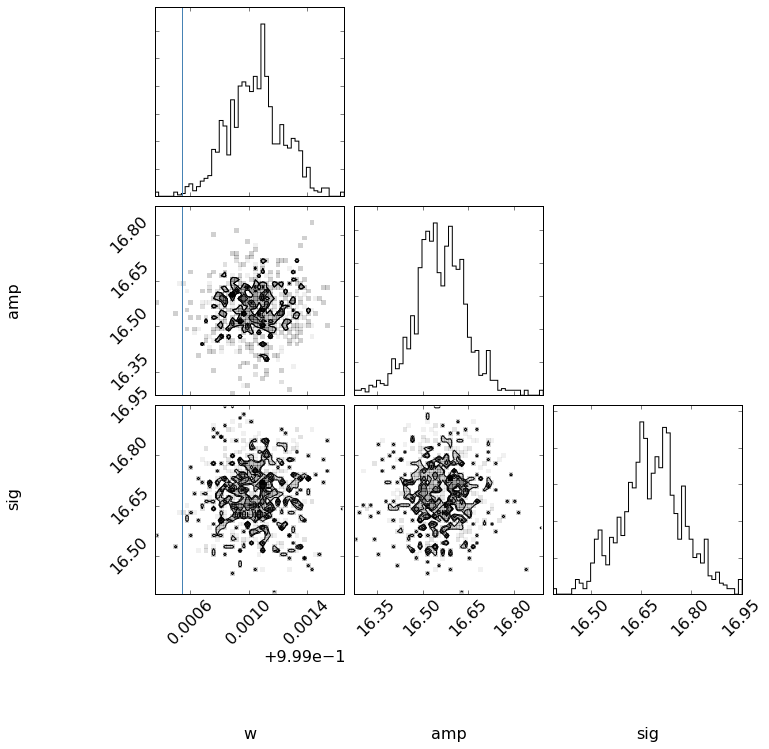

In [561]:
trifig, ax = plt.subplots(3, 3, figsize=(10, 10))
binnum = 7
fig2 = triangle.corner(samples[:, [-Nlightcurves-2*Nbins+binnum, -2*Nbins+binnum, 
                                   -Nbins+binnum]], 
                       labels=['w','amp','sig'], 
                       fig=trifig, plot_datapoints=False, 
                       truths=max_lnp_params[[-Nlightcurves-2*Nbins+binnum, -2*Nbins+binnum, 
                                   -Nbins+binnum]])
#, truths=max_lnp_params[0:4]) # truths=[t0_expected, aOverRs, RpOverRs, scale, 1]
#trifig.savefig('plots/linkedtriangle.png', bbox_inches='tight')
#trifig.savefig('/astro/users/bmmorris/Dropbox/2015aas225/plots/linkedtriangle.png', bbox_inches='tight')
plt.show()

## Print out results for Spitzer recalculation

In [95]:
spitzerparams = [0, 1, 3, 6, 7, 8, 9, 18, 19, 28, 29]
spitzerlabels = ['T14', 'b', 'midtrans', 'q1_ch1', 'q2_ch1', 'q1_ch2', 
                 'q2_ch2', 'RpRs_ch1', 'RpRs_ch2', 'F0_ch1', 'F0_ch2']
header = ['Parameter', 'Value', 'Upper', 'Lower']

writeins = ['e', 'omega', 'P']
writeinvalues = [eccentricity, periapse, period]

#T14b2aRsi(P, T14, b) #return aRs, i

with open('spitzerupdates.txt', 'w') as f:
    f.write('#'+'\t'.join(header)+'\n')
    for label, ind  in zip(spitzerlabels, spitzerparams):
        fit = medplusminus(samples[:,ind])
        fitpluslabel = [label] + map('{0:.8f}'.format, fit)
        f.write('\t'.join(fitpluslabel)+'\n')

        
    aRs, i = T14b2aRsi(period, samples[:,0], samples[:,1])
    for label, fit in zip(['a/Rs', 'i'], [medplusminus(aRs), medplusminus(i)]):
        fitpluslabel = [label] + map('{0:.8f}'.format, fit)
        f.write('\t'.join(fitpluslabel)+'\n')
        
    for label, val  in zip(writeins, writeinvalues):
        fitpluslabel = [label] + ['{0:.8f}'.format(val), 'FIXED', 'FIXED']
        f.write('\t'.join(fitpluslabel)+'\n')

In [96]:
%%bash
more spitzerupdates.txt

::::::::::::::
spitzerupdates.txt
::::::::::::::
#Parameter	Value	Upper	Lower
T14	0.09302195	0.00051475	0.00046361
b	0.06224207	0.13963678	0.22851563
midtrans	2456918.88483000	0.00020000	0.00020000
q1_ch1	0.02383571	0.03031314	0.01341892
q2_ch1	0.34432916	0.30571231	0.23688807
q1_ch2	0.01076548	0.00923049	0.00664085
q2_ch2	0.49753535	0.28325102	0.26432075
RpRs_ch1	0.13403137	0.00102746	0.00123704
RpRs_ch2	0.14236570	0.00110060	0.00107973
F0_ch1	0.99993748	0.00015160	0.00016300
F0_ch2	1.00009947	0.00017721	0.00019418
a/Rs	11.36851433	0.11486472	0.20060373
i	1.56537964	0.02005482	0.01249016
e	0.00000000	FIXED	FIXED
omega	1.57079633	FIXED	FIXED
P	3.36100239	FIXED	FIXED


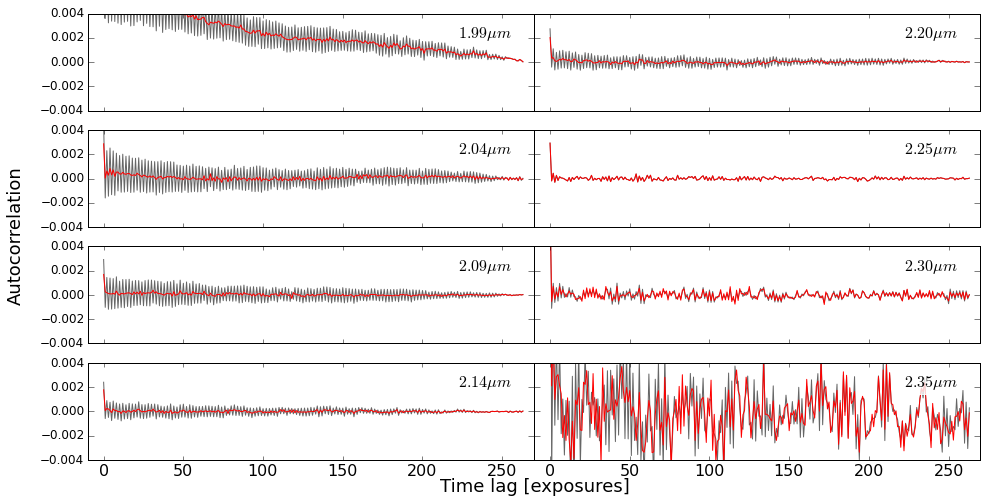

In [131]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

matplotlib.rcParams['ytick.major.size'] = 6
fig, ax = plt.subplots(Nbins/2, 2, figsize=(16,8), sharey='row', sharex='col')
gp_objs = []
kernellist = []
stimes = np.sort(times)
cosineperiod = 2*np.median(np.diff(stimes))

bestmidtransit = np.median(samples[:,2])
mtimes = (times - bestmidtransit)/period
spreadfactor = -0.05

allphases = mtimes.tolist()
for eachbin in range(len(lightcurve[0,:])):
    # Gaussian process parameters
    w = np.exp(useparams[-2*Nbins-Nlightcurves+eachbin])
    amp = np.exp(useparams[-2*Nbins+eachbin])
    sig = useparams[-Nbins+eachbin]
    
    gp_obj = george.GP(amp*kernels.ExpSquaredKernel(sig)*kernels.CosineKernel(cosineperiod))
    gp_obj.compute(times, (w/1e4)**0.5)
    
    transitresiduals = lightcurve[:,eachbin] - mosfiremodel[:,eachbin]
    mu, cov = gp_obj.predict(transitresiduals, times)
    
    # Airmass correction
    am = np.exp(samples[max_lnp_ind,30+eachbin])
    amcorrection = 1 + (airmass - 1)/am # Divide data, model by this
    
    xplotind = 0 if eachbin < 4 else 1
    yplotind = eachbin if eachbin < 4 else eachbin - 4
    # Baseline flux correction
    F0 = np.median(samples[:,20+eachbin])
    errorbarstyle = dict(fmt='.', 
                         ecolor='gray', capsize=0)
    # Raw light curves
    ax[yplotind, xplotind].plot(autocorr(transitresiduals), '#666666')
    #ax[0].plot(mtimes, (mosfiremodel[:,eachbin] + mu)/F0 + eachbin*spreadfactor, 'k')


    gptransitsubtracted = autocorr(transitresiduals - mu) #+ eachbin*spreadfactor + 1
    ax[yplotind, xplotind].plot(gptransitsubtracted, color='r')

    # Labels and limit
    #for i in range(2):
    ax[yplotind, xplotind].set_ylim([-0.004, 0.004])
    ax[yplotind, xplotind].set_xlim([-10, 270])
    xticks = np.arange(0, 275, 50)
    ax[yplotind, xplotind].set_xticks(xticks)
    yticks = np.arange(-0.004, 0.006, 0.002)
    ax[yplotind, xplotind].set_yticks(yticks)
    [tick.label.set_fontsize(12) for tick in ax[yplotind, xplotind].yaxis.get_major_ticks()]
    ax[yplotind, xplotind].annotate('${0:.2f} \mu m$'.format(wavelengthbincenters[eachbin]),
                   (0.95, 0.7), xycoords='axes fraction', 
                   ha='right', va='bottom', 
                   bbox=dict(facecolor='w', alpha=0.8,edgecolor='w'))
        
fig.subplots_adjust(wspace=0)

#ax[0, 0].set_title('Raw Residuals')
#ax[0, 1].set_title('Gaussian Process Removed')

bigax = fig.add_subplot(111)
bigax.set_ylabel('Autocorrelation', fontsize=18)
bigax.set_xlabel('Time lag [exposures]', fontsize=18)

sides = ['left', 'right', 'top', 'bottom']
for side in sides: 
    bigax.spines[side].set_visible(False)
bigax.set_xticks([])
bigax.set_yticks([])

bigax.xaxis.set_label_coords(0.5, -0.04)
bigax.yaxis.set_label_coords(-0.07, 0.5)

#savecopies(fig, 'autocorr')
plt.show()